# Data Distribution: Explore more diverse data distribution using different parameter sets
<!-- - Bimodal: small sigma_u and sigma_b rates, rho/d ~10, d =1
- Unimodal: increase sigma_u and sigma_b rates, rho/d ~10, rho -> 10 -->

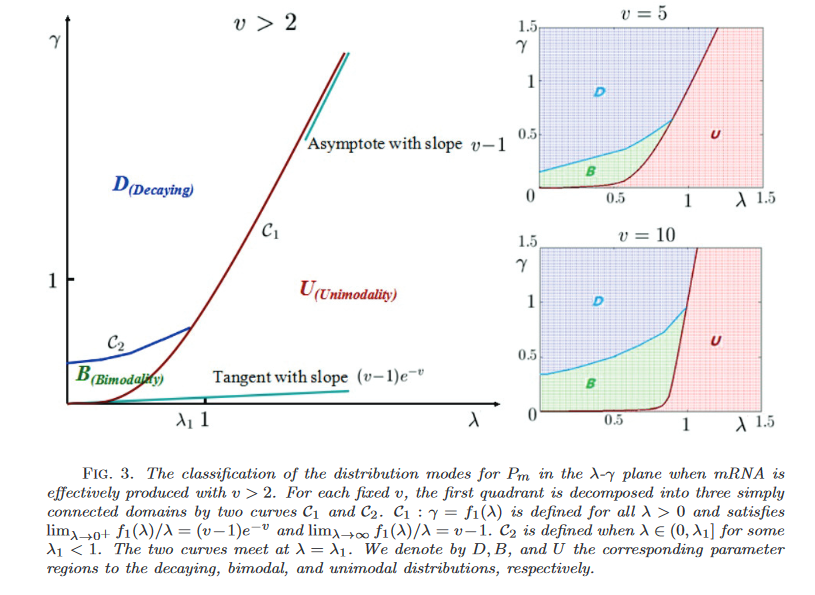

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import *
from ssa_analysis import *
from ssa_classification import *
%load_ext autoreload
%autoreload 2

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 0.1, 'sigma_b': 0.1, 'rho': 74.7041500841686, 'd': 1, 'label': 0}


Simulating Telegraph Model Systems:  50%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆ     | 1/2 [01:52<01:52, 112.20s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 0.05, 'sigma_b': 0.2, 'rho': 93.7500000000000, 'd': 1, 'label': 1}


Simulating Telegraph Model Systems: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 2/2 [05:32<00:00, 166.19s/it]



=== Statistical Report ===

ðŸ“Š **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 38.56
    - Variance: 1202.78

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 75.56
    - Variance: 1175.46
=== SVM (RBF Kernel) Classification Accuracy: 0.99 ===
=== Random Forest Accuracy: 1.00 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.74 ===
=== Random Classifier Accuracy: 0.42 ===


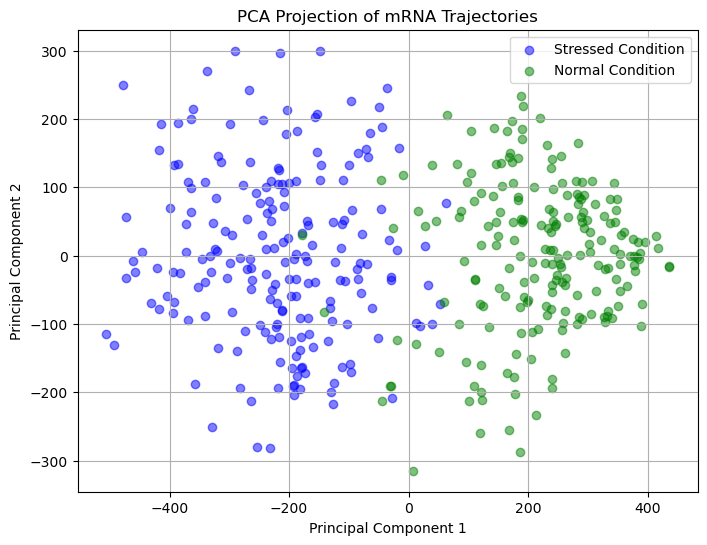

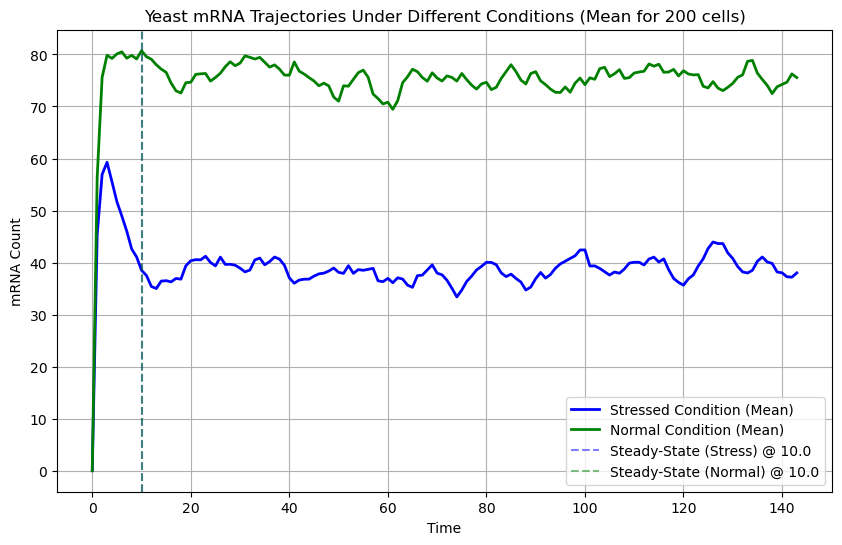

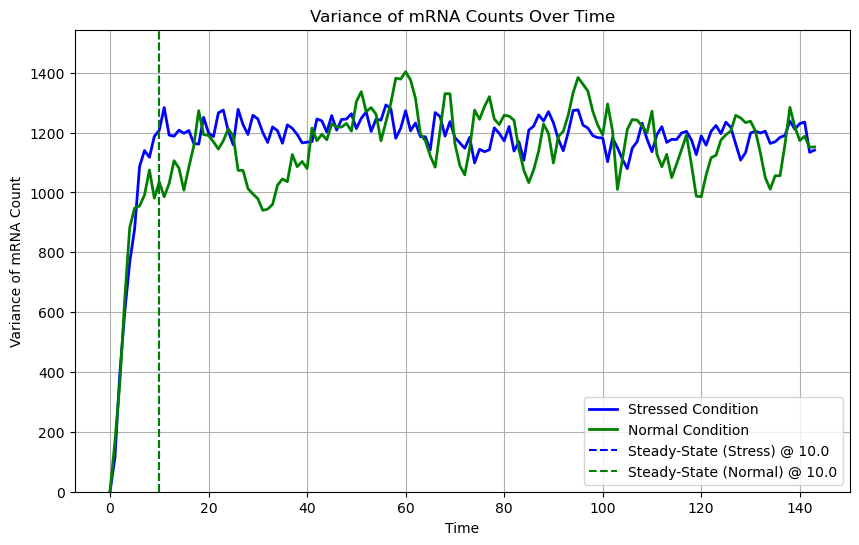


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 38.56, Variance = 1202.78
  Normal Condition (after 10.0 min): Mean = 75.56, Variance = 1175.46


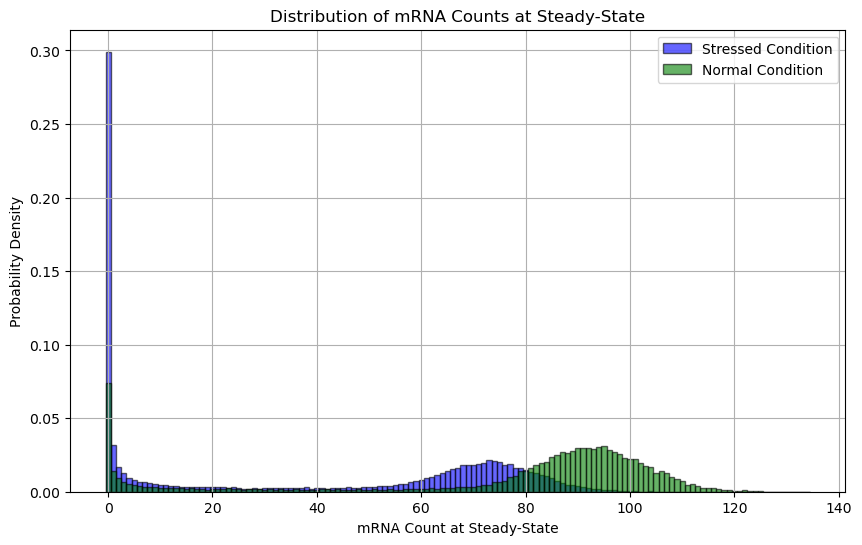

In [5]:
####### BIMODAL DISTRIBUTION + VAR FIXING #######
# Define system parameters
variance_target_stress = 1200.0  
variance_target_normal = 1200.0

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 0.1, 0.1  # Stressed Condition
sigma_u_normal, sigma_b_normal = 0.05, 0.2   # Normal Condition

# Define degradation rates
d_stress = d_normal = 1
# Transcription rates (rho) 
# rho_stress = rho_normal = 10.0

# Compute corresponding transcription rates (rho) using the given formula for variance
# Compute rho for stress condition using Mathematica's first solution
rho_stress = - (sigma_b_stress + sigma_u_stress) * sqrt(d_stress + sigma_b_stress + sigma_u_stress) * (sqrt(sigma_b_stress) * sqrt(d_stress + sigma_b_stress + sigma_u_stress) -sqrt(sigma_b_stress * (sigma_b_stress + sigma_u_stress) + d_stress * (sigma_b_stress + 4 * variance_target_stress * sigma_u_stress))) / (2 * sqrt(sigma_b_stress) * sigma_u_stress)

# Compute rho for normal condition using Mathematica's first solution
rho_normal = - (sigma_b_normal + sigma_u_normal) * sqrt(d_normal + sigma_b_normal + sigma_u_normal) * (sqrt(sigma_b_normal) * sqrt(d_normal + sigma_b_normal + sigma_u_normal) -sqrt(sigma_b_normal * (sigma_b_normal + sigma_u_normal) + d_normal * (sigma_b_normal + 4 * variance_target_normal * sigma_u_normal))) / (2 * sqrt(sigma_b_normal) * sigma_u_normal)

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_traj_bimodal_dist.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 0.3, 'sigma_b': 0.7, 'rho': 5.0, 'd': 1, 'label': 0}


Simulating Telegraph Model Systems:  50%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆ     | 1/2 [00:02<00:02,  2.73s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 0.5, 'sigma_b': 1, 'rho': 5.0, 'd': 1, 'label': 1}


Simulating Telegraph Model Systems: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 2/2 [00:05<00:00,  2.65s/it]



=== Statistical Report ===

ðŸ“Š **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 3.48
    - Variance: 6.07

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 3.35
    - Variance: 5.56


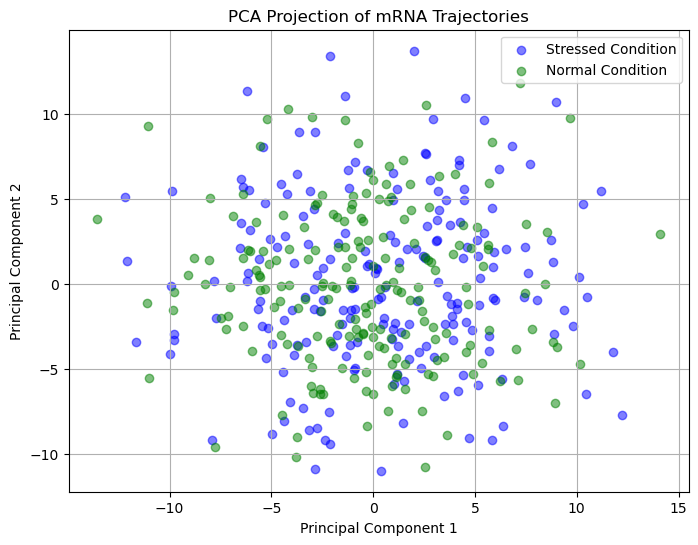

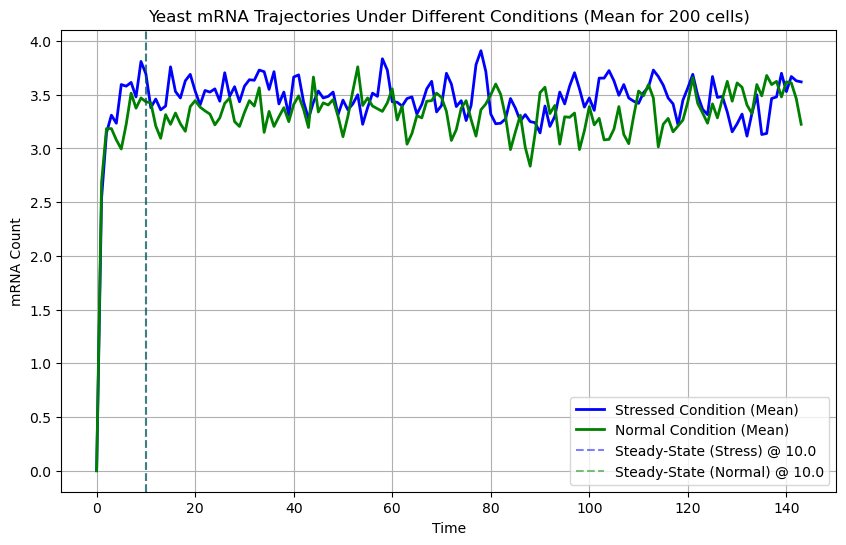

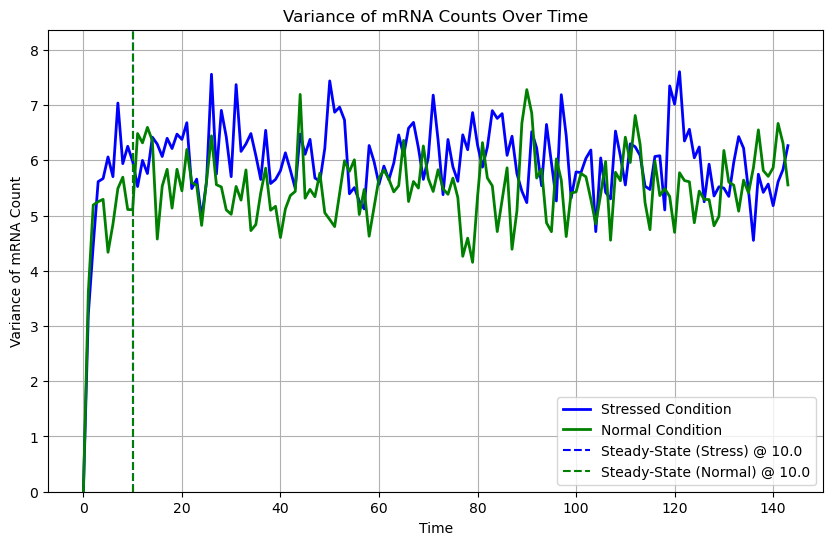


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 3.48, Variance = 6.07
  Normal Condition (after 10.0 min): Mean = 3.35, Variance = 5.56


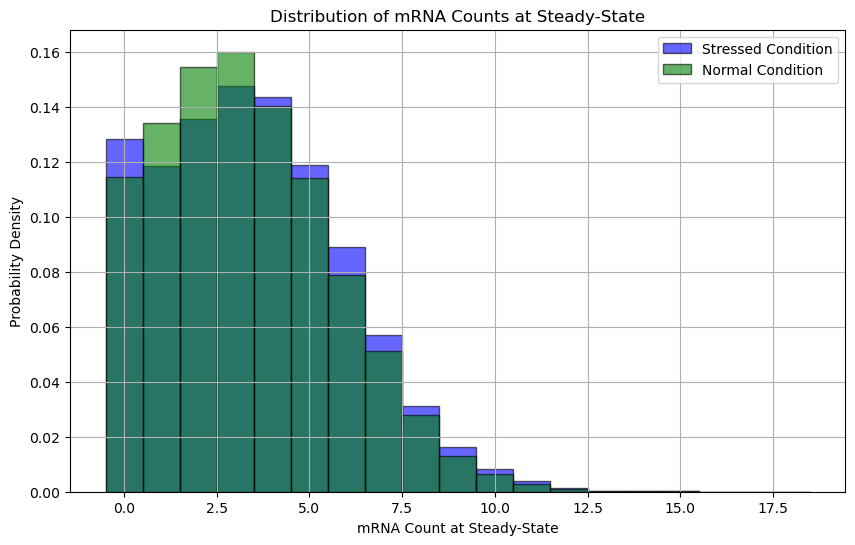

In [4]:
####### UNIMODAL DISTRIBUTION #######
# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 0.3, 0.7  # Stressed Condition
sigma_u_normal, sigma_b_normal = 0.5, 1   # Normal Condition

# Define degradation rates
d_stress = d_normal = 1
# Transcription rates (rho) 
# rho_stress = rho_normal = 10.0

# Compute corresponding transcription rates (rho) using the given formula for variance
# Compute rho for stress condition using Mathematica's first solution
rho_stress = rho_normal = 5.0

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_traj_unimodal_dist.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 0.1, 'sigma_b': 0.1, 'rho': 20.0, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆ     | 1/2 [00:08<00:08,  8.27s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 0.05, 'sigma_b': 0.2, 'rho': 12.5, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 2/2 [00:16<00:00,  8.19s/it]



=== Statistical Report ===

ðŸ“Š **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 9.84
    - Variance: 91.91

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 9.96
    - Variance: 29.90
=== SVM (RBF Kernel) Classification Accuracy: 1.00 ===
=== Random Forest Accuracy: 1.00 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.56 ===
=== Random Classifier Accuracy: 0.46 ===


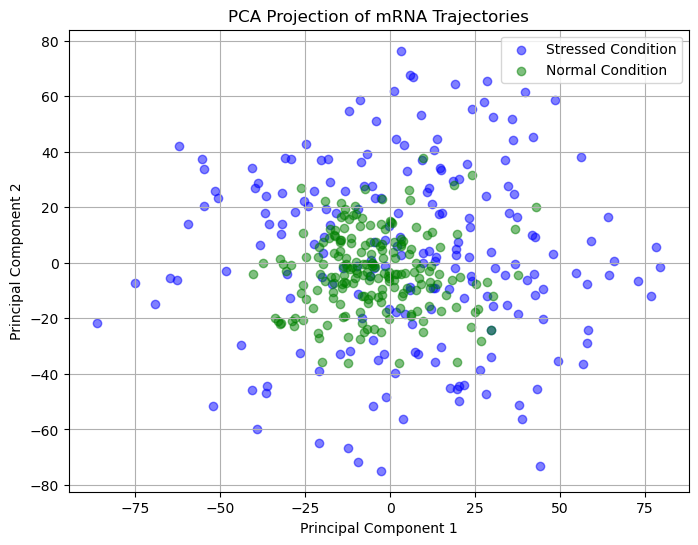

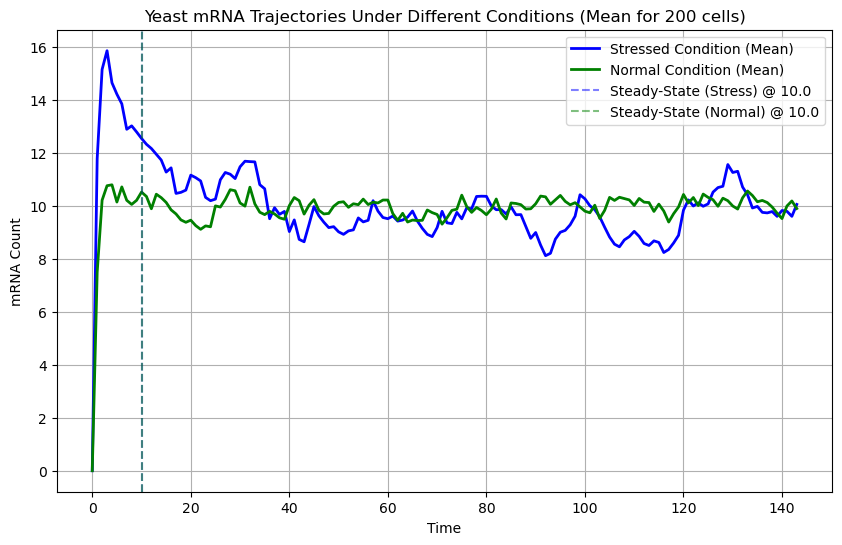

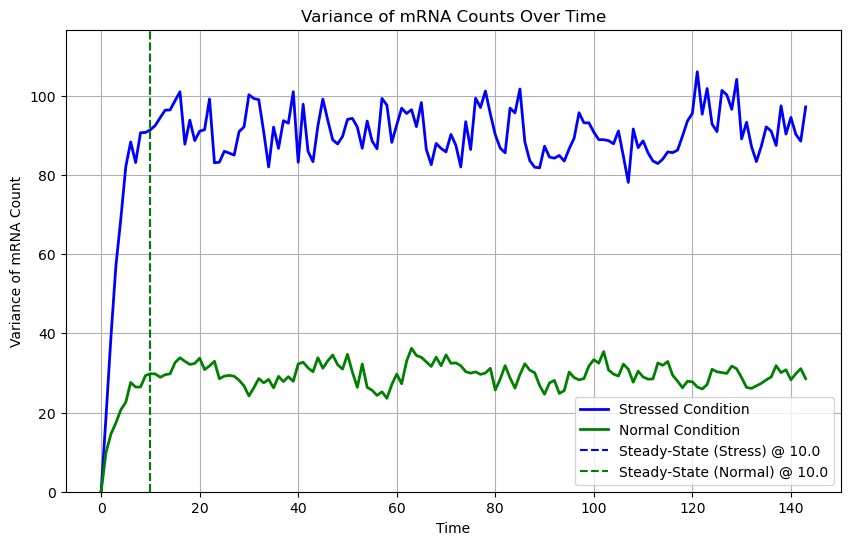


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 9.84, Variance = 91.91
  Normal Condition (after 10.0 min): Mean = 9.96, Variance = 29.90


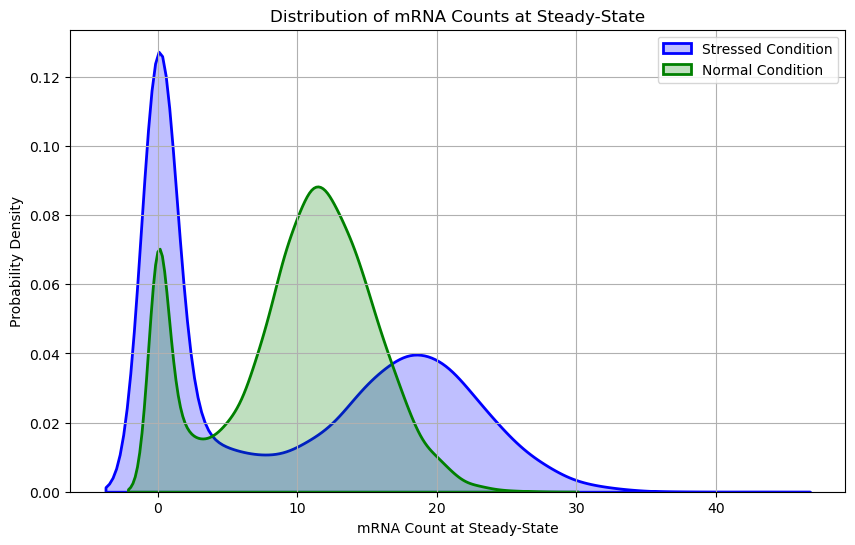

In [5]:
####### BIMODAL DISTRIBUTION + MEAN FIXING #######
# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 0.1, 0.1  # Stressed Condition
sigma_u_normal, sigma_b_normal = 0.05, 0.2   # Normal Condition

# Define degradation rates
d_stress = d_normal = 1.0

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points

size = 200  # Reduce number of simulations per condition for efficiency

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = "data/mRNA_traj_mean_fixed_bimodal.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)

In [ ]:
####### POISSON DISTRIBUTION + MEAN FIXING #######
# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 0.1, 0.1  # Stressed Condition
sigma_u_normal, sigma_b_normal = 0.05, 0.2   # Normal Condition

# Define degradation rates
d_stress = d_normal = 1.0

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points

size = 200  # Reduce number of simulations per condition for efficiency

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = "data/mRNA_traj_mean_fixed_bimodal.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)

In [ ]:
# Define parameters for two different data distributions
params_bimodal = {"sigma_u": 0.1, "sigma_b": 0.1, "rho": 10.0, "d": 1.0, "label": 0} # the label  here doens't mean anything
params_poisson = {"sigma_u": 1.0, "sigma_b": 1.0, "rho": 10.0, "d": 1.0, "label": 1} # the label  here doens't mean anything

# Set up simulation parameters
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step
size = 200  # Size of the simulation

# Run the simulation function for both parameter sets
df_results_bimodal = simulate_one_telegraph_model_system(params_bimodal, time_points, size)
df_results_poisson = simulate_one_telegraph_model_system(params_poisson, time_points, size)

# Save datasets for ML classification
output_file_bimodal = "data/mRNA_traj_bimodal_dist.csv"
output_file_poisson = "data/mRNA_traj_poisson_dist.csv"
df_results_bimodal.to_csv(output_file_bimodal, index=False)
df_results_poisson.to_csv(output_file_poisson, index=False)


Simulating Telegraph Model Systems:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 0.1, 'sigma_b': 0.1, 'rho': 10.0, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 0.1, 'sigma_b': 0.1, 'rho': 10.0, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 1.0, 'sigma_b': 1.0, 'rho': 10.0, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:04<00:00,  4.03s/it]


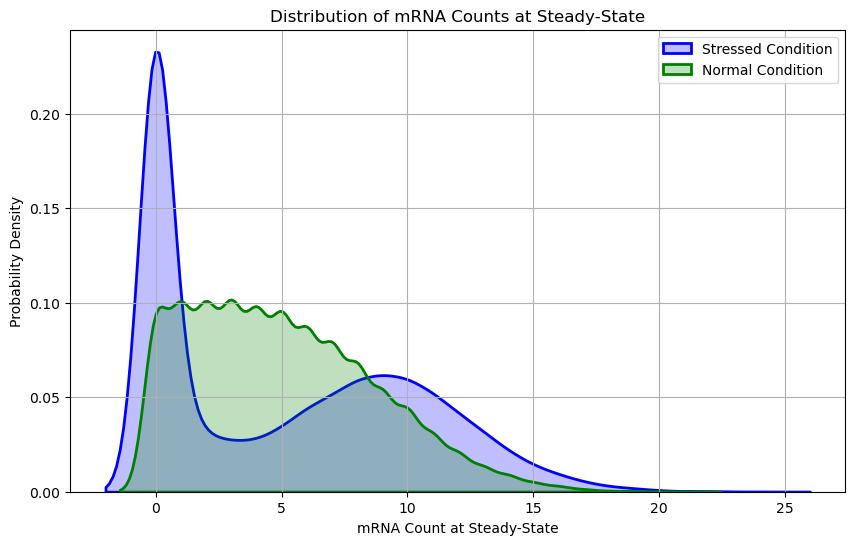

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [26]:
# Extract mRNA trajectories for each condition
bimodal_trajectories = df_results_bimodal[df_results_bimodal['label'] == 0].iloc[:, 1:].values  # Stressed Condition
poisson_trajectories = df_results_poisson[df_results_poisson['label'] == 1].iloc[:, 1:].values  # Normal condition
# plots
plot_mRNA_dist([params_bimodal, params_poisson], bimodal_trajectories, poisson_trajectories)
plot_mRNA_trajectory([params_bimodal, bimodal_trajectories], time_points, df_results_bimodal, df_results_poisson)

plot_mRNA_variance([params_bimodal, bimodal_trajectories], time_points, df_results_bimodal, df_results_poisson)

In [12]:
def calculate_parameters(avg, var, autocorr_time):
    """
    Calculate the parameters sigma_u, sigma_b, and rho based on the given average, variance, and autocorrelation time.
    
    Parameters:
    avg (float): The desired average.
    var (float): The desired variance.
    autocorr_time (float): The desired autocorrelation time.
    
    Returns:
    dict: A dictionary containing the calculated parameters.
    """
    # Example calculation (you may need to adjust this based on your specific model)
    sigma_u = var / avg
    sigma_b = var / (avg * autocorr_time)
    rho = avg * autocorr_time
    
    return {"sigma_u": sigma_u, "sigma_b": sigma_b, "rho": rho, "d": 1.0, "label": 0}

# Example usage
avg = 10.0
var = 5.0
autocorr_time = 2.0

params = calculate_parameters(avg, var, autocorr_time)
print(params)

# Now you can use these parameters to run the simulation
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step
size = 200  # Size of the simulation

df_results = simulate_one_telegraph_model_system(params, time_points, size)
print(df_results)

{'sigma_u': 0.5, 'sigma_b': 0.25, 'rho': 20.0, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 0.5, 'sigma_b': 0.25, 'rho': 20.0, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:04<00:00,  4.69s/it]

     label  time_0.0  time_1.0  time_2.0  time_3.0  time_4.0  time_5.0  \
0        0         0        16         8         2         8        17   
1        0         0         9         4         1        11        13   
2        0         0        17        16         6         2         0   
3        0         0        10        20        30        26        17   
4        0         0        11        19        14        14        21   
..     ...       ...       ...       ...       ...       ...       ...   
195      0         0        16        15        14        15        17   
196      0         0         9        16        20        16         8   
197      0         0        22        26        24        11         2   
198      0         0         1         1         0         0         0   
199      0         0        14        24        16         4         1   

     time_6.0  time_7.0  time_8.0  ...  time_134.0  time_135.0  time_136.0  \
0          20        25        21

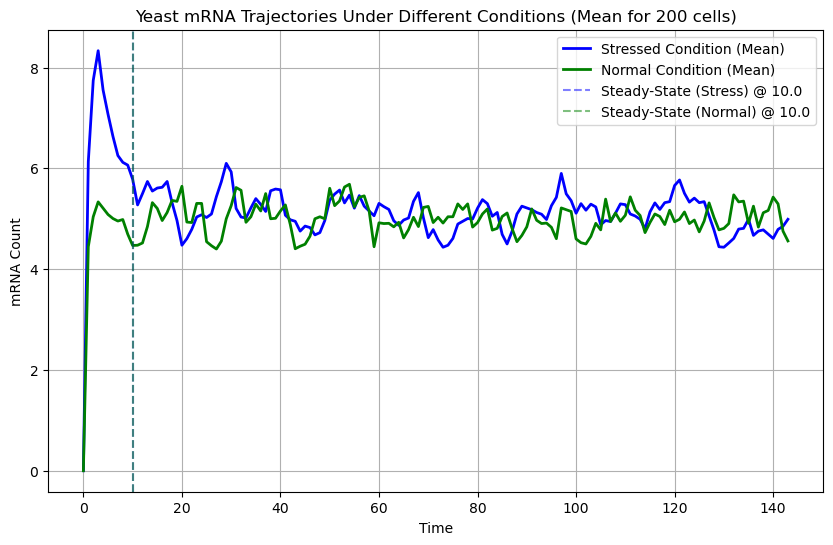